In [1]:
import os

os.environ["TOKENIZERS_PARALLELISM"] = "true"
from PIL import Image
from tqdm import tqdm
import numpy as np
import torch
# import wandb
from models import Showo, MAGVITv2, get_mask_chedule
from training.prompting_utils import UniversalPrompting, create_attention_mask_predict_next
from training.utils import get_config, flatten_omega_conf, image_transform
from transformers import AutoTokenizer
import torch.nn.functional as F

/home/hpyky/miniconda3/envs/showo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-02-06 21:34:18,552] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)
 [WARNING]  async_io requires the dev libaio .so object and headers but these were not found.


/home/hpyky/miniconda3/envs/showo/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


 [WARNING]  async_io: please install the libaio-dev package with apt
 [WARNING]  If libaio is already installed (perhaps from source), try setting the CFLAGS and LDFLAGS environment variables to where it can be found.
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH
 [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.2
 [WARNING]  using untested triton version (2.2.0), only 1.0.0 is known to be compatible


In [2]:
def get_vq_model_class(model_type):
    # if model_type == "magvitv2":
    return MAGVITv2
    # else:
    #     raise ValueError(f"model_type {model_type} not supported.")

In [3]:
from omegaconf import DictConfig, ListConfig, OmegaConf
config = OmegaConf.load('configs/showo_demo.yaml')
config.mode = 't2i'
config.batch_size = 1
config.generation_timesteps = 50
config.guidance_scale = 5
config.validation_prompts_file = 'validation_prompts/showoprompts.txt'

In [4]:
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(config.model.showo.llm_model_path, padding_side="left")

uni_prompting = UniversalPrompting(tokenizer, max_text_len=config.dataset.preprocessing.max_seq_length,
                                    special_tokens=("<|soi|>", "<|eoi|>", "<|sov|>", "<|eov|>", "<|t2i|>", "<|mmu|>", "<|t2v|>", "<|v2v|>", "<|lvg|>"),
                                    ignore_id=-100, cond_dropout_prob=config.training.cond_dropout_prob)

vq_model = get_vq_model_class(config.model.vq_model.type)
vq_model = vq_model.from_pretrained(config.model.vq_model.vq_model_name).to(device)
vq_model.requires_grad_(False)
vq_model.eval()

model = Showo.from_pretrained(config.model.showo.pretrained_model_path).to(device)
model.eval()

mask_token_id = model.config.mask_token_id

# load from users passed arguments
config.training.batch_size = config.batch_size
config.training.guidance_scale = config.guidance_scale
config.training.generation_timesteps = config.generation_timesteps

Working with z of shape (1, 13, 16, 16) = 3328 dimensions.
Look-up free quantizer with codebook size: 8192


The config attributes {'mask_token_id': 58497} were passed to Showo, but are not expected and will be ignored. Please verify your config.json configuration file.


attention implementation:  sdpa


/home/hpyky/Show-o/models/modeling_showo.py:49: FutureWarning: Accessing config attribute `w_clip_vit` directly via 'Showo' object attribute is deprecated. Please access 'w_clip_vit' over 'Showo's config object instead, e.g. 'unet.config.w_clip_vit'.
  if self.w_clip_vit:


In [5]:
step = 0
prompt = "Captain America's shield"

image_tokens = torch.ones((1, config.model.showo.num_vq_tokens),
                            dtype=torch.long, device=device) * mask_token_id    # shape [batch, num_vq_tokens] [1, 256], fill with mask token
# mask id == 58497
# id 50295 == [PAD]
# id 50256 == <|endoftext|>
# id 50300 == <|t2i|>
# id 50296 == <|soi|>
# id 50297 == <|eoi|>

input_ids, _ = uni_prompting(([prompt], image_tokens), 't2i_gen')   # [1, 387]
# [1, 387], prompt == A cute dog, == [PAD] * 123 + <|t2i|><|endoftext|> + prompt + <|endoftext|><|soi|> + [MASK] * 256 + <|eoi|>
# [1, 387], prompt == A cute dog, == [PAD] * 120 + <|t2i|><|endoftext|> + prompt + <|endoftext|><|soi|> + [MASK] * 256 + <|eoi|>

if config.training.guidance_scale > 0:
    uncond_input_ids, _ = uni_prompting(([''] * 1, image_tokens), 't2i_gen')
    # [1, 387], == [PAD] * 126 + <|t2i|> + <|endoftext|> + <|endoftext|> + <|soi|> + [MASK] * 256 + <|eoi|> ## no prompt
    attention_mask = create_attention_mask_predict_next(torch.cat([input_ids, uncond_input_ids], dim=0),    # [2, 387]
                                                        pad_id=int(uni_prompting.sptids_dict['<|pad|>']),
                                                        soi_id=int(uni_prompting.sptids_dict['<|soi|>']),
                                                        eoi_id=int(uni_prompting.sptids_dict['<|eoi|>']),
                                                        rm_pad_in_image=True)
else:
    attention_mask = create_attention_mask_predict_next(input_ids,
                                                        pad_id=int(uni_prompting.sptids_dict['<|pad|>']),
                                                        soi_id=int(uni_prompting.sptids_dict['<|soi|>']),
                                                        eoi_id=int(uni_prompting.sptids_dict['<|eoi|>']),
                                                        rm_pad_in_image=True)
    uncond_input_ids = None
# attention_mask [2, 1, 387, 387]

import matplotlib.pyplot as plt
# draw attention mask, with label to show the num
am0 = attention_mask[0].squeeze(0).cpu().numpy()
am1 = attention_mask[1].squeeze(0).cpu().numpy()

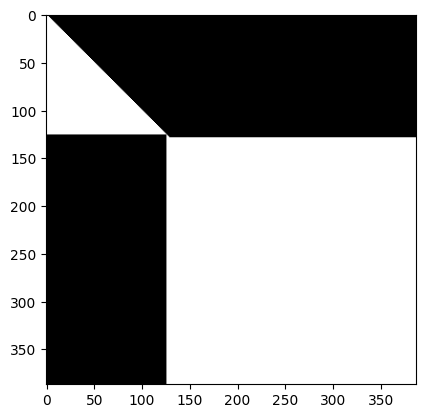

In [6]:
# am0 == 0，则显示白色，否则显示黑色
# am1 == 0，则显示白色，否则显示黑色
# am1_am0 = am1 - am0

plt.imshow(am1, cmap='gray')


In [7]:
if config.get("mask_schedule", None) is not None:
    schedule = config.mask_schedule.schedule
    args = config.mask_schedule.get("params", {})
    mask_schedule = get_mask_chedule(schedule, **args)
else:
    mask_schedule = get_mask_chedule(config.training.get("mask_schedule", "cosine"))


In [8]:
mask_schedule

<function models.sampling.cosine_schedule(t)>

In [9]:
input_ids.shape

torch.Size([1, 387])

In [10]:

with torch.no_grad():
    gen_token_ids = model.t2i_generate(
        input_ids=input_ids,
        uncond_input_ids=uncond_input_ids,
        attention_mask=attention_mask,
        guidance_scale=config.training.guidance_scale,
        temperature=config.training.get("generation_temperature", 1.0),
        timesteps=config.training.generation_timesteps,
        noise_schedule=mask_schedule,
        noise_type=config.training.get("noise_type", "mask"),
        seq_len=config.model.showo.num_vq_tokens,
        uni_prompting=uni_prompting,
        config=config,
    )




In [52]:
gen_token_ids.shape

torch.Size([1, 256])

In [53]:
gen_token_ids = torch.clamp(gen_token_ids, max=config.model.showo.codebook_size - 1, min=0)
gen_token_ids

tensor([[4706, 6511, 4451, 4206, 4133, 4218, 4342, 4331, 4195, 4349, 4965, 6250,
         4712, 4195, 4198, 7023, 4450, 4714, 8174, 6437, 5429, 7957, 4391, 7021,
         6270, 6950, 5039, 6044, 5481, 4464, 6703, 7022, 6383, 6565, 4707, 1676,
          354, 6856, 5888,  865, 3434, 1734, 6538, 1252, 1077, 6702, 4585, 4195,
         4449, 5261, 1536, 5845, 6332, 5221, 1033, 2903, 4467, 1069, 5722, 5232,
         1604, 1168, 1045, 6190, 4390, 8016, 5100, 1612, 5932,  148, 7748, 6933,
         6437, 4252, 1236, 8053, 1344, 4933, 6092, 7025, 6218, 4835, 8052, 4700,
         4537, 7561, 5512, 3532, 3144, 5266, 7944, 6513, 6487, 4329, 4144, 4207,
         4843, 4470, 4297, 8188, 4096, 4104, 4876, 7615, 7615,  817, 3109,   10,
         5233, 7060, 4351, 4455, 6247, 4427, 4258, 6599, 6773, 1373, 7996, 5166,
         6471, 1380, 2001, 6717, 5453, 6497, 4199, 7018, 4390, 4971, 5164, 7398,
         3968, 4789, 8031, 7720, 4339, 4046, 4149, 3780, 7272, 5218, 4399, 7022,
         6763, 6254, 6007, 5

In [12]:
images = vq_model.decode_code(gen_token_ids)

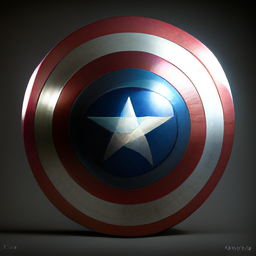

In [13]:


images = torch.clamp((images + 1.0) / 2.0, min=0.0, max=1.0)
images *= 255.0
images = images.permute(0, 2, 3, 1).cpu().numpy().astype(np.uint8)
pil_images = [Image.fromarray(image) for image in images]

pil_images[0].show()